# **GRIP - The Sparks Foundation**
## **Data Science and Business Analytics Intern**

### **Task 7 : Stock Market Prediction using Numerical and Textual Analysis**

**Objectif :** Create a hybrid model for stock price/performance prediction using
numerical analysis of historical stock prices, and sentimental analysis of news headlines.

**Name :** Maryem Benslimene



### **Importing libraries**

In [ ]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## **Reading datasets**

In [ ]:
#News headlines dataset
headlines = pd.read_csv('india-news-headlines (1).csv')
headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [ ]:
#Historical stock prices dataset
prices = pd.read_csv('^IXIC (5).csv')
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-09-15,2202.280029,2244.879883,2179.909912,2179.909912,2179.909912,2697820000
1,2008-09-16,2149.649902,2214.290039,2145.169922,2207.899902,2207.899902,3187630000
2,2008-09-17,2177.580078,2183.250000,2098.850098,2098.850098,2098.850098,3102010000
3,2008-09-18,2137.419922,2201.709961,2070.219971,2199.100098,2199.100098,3867290000
4,2008-09-19,2303.899902,2318.429932,2239.729980,2273.899902,2273.899902,3898230000


### **Analyzing the news headlines dataset**

In [ ]:
headlines.shape

(3650970, 3)

In [ ]:
headlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


In [ ]:
headlines.duplicated().sum()

24860

In [ ]:
headlines = hesdlines.drop_duplicates(keep='first')
headlines.duplicated().sum()

In [ ]:
headlines.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [ ]:
headlines['headline_category'].value_counts()

india                                                    297491
unknown                                                  209583
city.mumbai                                              150451
city.delhi                                               137648
business.india-business                                  121195
                                                          ...  
nepal-india-earthquake.opinion                                8
elections.lok-sabha-elections-2019.tripura.news               8
best-products.home-decor-and-garden.living-room-decor         8
profiles.india-profiles                                       8
pms-us-visit                                                  8
Name: headline_category, Length: 1041, dtype: int64

In [ ]:
headlines['publish_date'] = pd.to_datetime(headlines['publish_date'],format='%Y%m%d')
headlines = headlines.rename(columns={'publish_date':'Date'})
headlines.tail()

,Date,headline_category,headline_text
3650965,2022-03-31,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650966,2022-03-31,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,2022-03-31,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650968,2022-03-31,city.erode,Tamil Nadu sees marginal rise of Covid cases w...
3650969,2022-03-31,city.salem,Tamil Nadu sees marginal rise of Covid cases w...


In [ ]:
headlines = headlines[headlines['Date'] >= '2008-09-15']
headlines = headlines[headlines['Date'] <= '2008-09-30' ]
headlines.shape

(6809, 3)

In [ ]:
headlines = headlines.sort_values('Date')

In [ ]:
headlines = headlines.drop('headline_category',axis=1)

In [ ]:
headlines.reset_index()

,index,Date,headline_text
0,618726,2008-09-15,Pregnant? Watch your weight!
1,619031,2008-09-15,Cesc Fabregas
2,619030,2008-09-15,10 youth walk backwards for environment
3,619029,2008-09-15,Should there be vacation in schools and colleg...
4,619028,2008-09-15,Failure of middle-order in Lanka a one-off thi...
...,...,...,...
6804,625292,2008-09-30,3 held for killing fruit stall owner
6805,625291,2008-09-30,Draft law tightens surrogacy norms
6806,625290,2008-09-30,Blame the brats; not the car
6807,625310,2008-09-30,N-deal has dehyphenated India from Pakistan: C...


In [ ]:
#Number of words in each headline text
headlines['word_count'] = headlines['headline_text'].apply(lambda x : len(str(x).split(' ')))
headlines.head()

,Date,headline_text,word_count
618726,2008-09-15,Pregnant? Watch your weight!,4
619031,2008-09-15,Cesc Fabregas,2
619030,2008-09-15,10 youth walk backwards for environment,6
619029,2008-09-15,Should there be vacation in schools and colleg...,10
619028,2008-09-15,Failure of middle-order in Lanka a one-off thi...,9


In [ ]:
#Number of characters in each headline text
headlines['char_count'] = headlines['headline_text'].str.len()
headlines.head()

,Date,headline_text,word_count,char_count
618726,2008-09-15,Pregnant? Watch your weight!,4,28
619031,2008-09-15,Cesc Fabregas,2,13
619030,2008-09-15,10 youth walk backwards for environment,6,39
619029,2008-09-15,Should there be vacation in schools and colleg...,10,65
619028,2008-09-15,Failure of middle-order in Lanka a one-off thi...,9,60


In [ ]:
#Calculating average word length
def avg_word(sentence):
    words = sentence.split()
    return (sum([len(x) for x in words])/len(words))
headlines['avg_word'] = headlines['headline_text'].apply(lambda x : avg_word(x))
headlines.head()

,Date,headline_text,word_count,char_count,avg_word
618726,2008-09-15,Pregnant? Watch your weight!,4,28,6.250000
619031,2008-09-15,Cesc Fabregas,2,13,6.000000
619030,2008-09-15,10 youth walk backwards for environment,6,39,5.666667
619029,2008-09-15,Should there be vacation in schools and colleg...,10,65,5.600000
619028,2008-09-15,Failure of middle-order in Lanka a one-off thi...,9,60,5.777778


## **Preprocess the news headline data**

In [ ]:
#Converting every word to upper case
headlines['headline_text'] = headlines['headline_text'].apply(lambda x : ' '.join(x.lower() for x in x.split()))
headlines['headline_text']

618726                         pregnant? watch your weight!
619031                                        cesc fabregas
619030              10 youth walk backwards for environment
619029    should there be vacation in schools and colleg...
619028    failure of middle-order in lanka a one-off thi...
                                ...                        
625292                 3 held for killing fruit stall owner
625291                   draft law tightens surrogacy norms
625290                         blame the brats; not the car
625310    n-deal has dehyphenated india from pakistan: c...
625534    sparkling opening of 39-room hotel at baga in goa
Name: headline_text, Length: 6809, dtype: object

In [ ]:
#Removing punctuations
headlines['headline_text'] = headlines['headline_text'].str.replace('[^\w\s]','')
headlines['headline_text']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


618726                           pregnant watch your weight
619031                                        cesc fabregas
619030              10 youth walk backwards for environment
619029    should there be vacation in schools and colleg...
619028    failure of middleorder in lanka a oneoff thing...
                                ...                        
625292                 3 held for killing fruit stall owner
625291                   draft law tightens surrogacy norms
625290                          blame the brats not the car
625310    ndeal has dehyphenated india from pakistan con...
625534     sparkling opening of 39room hotel at baga in goa
Name: headline_text, Length: 6809, dtype: object

In [ ]:
#Removing stopwords
sw = stopwords.words('english')
headlines['headline_text'] = headlines['headline_text'].apply(lambda x : ' '.join(x for x in x.split() if x not in sw))
headlines['headline_text']

618726                                pregnant watch weight
619031                                        cesc fabregas
619030                  10 youth walk backwards environment
619029                   vacation schools colleges navratri
619028    failure middleorder lanka oneoff thing vengsarkar
                                ...                        
625292                     3 held killing fruit stall owner
625291                   draft law tightens surrogacy norms
625290                                      blame brats car
625310           ndeal dehyphenated india pakistan congress
625534              sparkling opening 39room hotel baga goa
Name: headline_text, Length: 6809, dtype: object

In [ ]:
#Counting commun words
freq_comm = pd.Series(' '.join(headlines['headline_text']).split()).value_counts()[:10]
freq_comm

india     194
us        156
delhi     143
new       133
terror    133
govt      115
cops      114
rs        100
may        98
get        95
dtype: int64

In [ ]:
#Removing commun words
freq = list(freq_comm.index)
headlines['headline_text'] = headlines['headline_text'].apply(lambda x : ' '.join(x for x in x.split() if x not in freq))
headlines['headline_text']

618726                                pregnant watch weight
619031                                        cesc fabregas
619030                  10 youth walk backwards environment
619029                   vacation schools colleges navratri
619028    failure middleorder lanka oneoff thing vengsarkar
                                ...                        
625292                     3 held killing fruit stall owner
625291                   draft law tightens surrogacy norms
625290                                      blame brats car
625310                 ndeal dehyphenated pakistan congress
625534              sparkling opening 39room hotel baga goa
Name: headline_text, Length: 6809, dtype: object

In [ ]:
#Counting rare words
freq_rare = pd.Series(' '.join(headlines['headline_text']).split()).value_counts()[-50:]
freq_rare.head()

kotla          1
feroz          1
chinnaswamy    1
ascetics       1
diary          1
dtype: int64

In [ ]:
#Removing rare words
freq = list(freq_rare.index)
headlines['headline_text'] = headlines['headline_text'].apply(lambda x : ' '.join(x for x in x.split() if x not in freq_rare))
headlines['headline_text']

618726                                pregnant watch weight
619031                                        cesc fabregas
619030                  10 youth walk backwards environment
619029                   vacation schools colleges navratri
619028    failure middleorder lanka oneoff thing vengsarkar
                                ...                        
625292                     3 held killing fruit stall owner
625291                   draft law tightens surrogacy norms
625290                                      blame brats car
625310                              ndeal pakistan congress
625534              sparkling opening 39room hotel baga goa
Name: headline_text, Length: 6809, dtype: object

In [ ]:
#Tokenization
TextBlob(str(headlines['headline_text'])).words

WordList(['618726', 'pregnant', 'watch', 'weight', '619031', 'cesc', 'fabregas', '619030', '10', 'youth', 'walk', 'backwards', 'environment', '619029', 'vacation', 'schools', 'colleges', 'navratri', '619028', 'failure', 'middleorder', 'lanka', 'oneoff', 'thing', 'vengsarkar', '625292', '3', 'held', 'killing', 'fruit', 'stall', 'owner', '625291', 'draft', 'law', 'tightens', 'surrogacy', 'norms', '625290', 'blame', 'brats', 'car', '625310', 'ndeal', 'pakistan', 'congress', '625534', 'sparkling', 'opening', '39room', 'hotel', 'baga', 'goa', 'Name', 'headline_text', 'Length', '6809', 'dtype', 'object'])

In [ ]:
#Stemming
ps = PorterStemmer()
headlines['headline_text'].apply(lambda x : ' '.join(ps.stem(word) for word in x.split()))

618726                             pregnant watch weight
619031                                      cesc fabrega
619030                    10 youth walk backward environ
619029                      vacat school colleg navratri
619028    failur middleord lanka oneoff thing vengsarkar
                               ...                      
625292                     3 held kill fruit stall owner
625291                  draft law tighten surrogaci norm
625290                                    blame brat car
625310                           ndeal pakistan congress
625534                 sparkl open 39room hotel baga goa
Name: headline_text, Length: 6809, dtype: object

### **Performing sentiment analysis for each headline text**

In [ ]:
headlines['sentiment'] = headlines['headline_text'].apply(lambda x : TextBlob(x).sentiment[0])
headlines[['headline_text','sentiment']]

,headline_text,sentiment
618726,pregnant watch weight,0.333333
619031,cesc fabregas,0.000000
619030,10 youth walk backwards environment,0.000000
619029,vacation schools colleges navratri,0.000000
619028,failure middleorder lanka oneoff thing vengsarkar,-0.316667
...,...,...
625292,3 held killing fruit stall owner,0.000000
625291,draft law tightens surrogacy norms,0.000000
625290,blame brats car,0.000000
625310,ndeal pakistan congress,0.000000


In [ ]:
headlines = headlines[['Date','headline_text','sentiment']].reset_index()
headlines = headlines.drop('index',axis=1)
headlines.head()

,Date,headline_text,sentiment
0,2008-09-15,pregnant watch weight,0.333333
1,2008-09-15,cesc fabregas,0.000000
2,2008-09-15,10 youth walk backwards environment,0.000000
3,2008-09-15,vacation schools colleges navratri,0.000000
4,2008-09-15,failure middleorder lanka oneoff thing vengsarkar,-0.316667


### **Analysing historical market prices dataset**

In [ ]:
prices.shape

(12, 7)

In [ ]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12 non-null     object 
 1   Open       12 non-null     float64
 2   High       12 non-null     float64
 3   Low        12 non-null     float64
 4   Close      12 non-null     float64
 5   Adj Close  12 non-null     float64
 6   Volume     12 non-null     int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 800.0+ bytes


In [ ]:
prices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01
mean,2174.335815,2205.319153,2126.296682,2157.764160,2157.764160,2.617197e+09
std,67.194108,56.228775,72.702868,72.774697,72.774697,7.686672e+08
min,2033.689941,2094.310059,1983.729980,1983.729980,1983.729980,1.818170e+09
25%,2146.384949,2182.419983,2091.692566,2139.710083,2139.710083,1.932190e+09
50%,2169.905029,2205.665039,2146.265014,2179.444946,2179.444946,2.537030e+09
75%,2193.602478,2221.937500,2170.040039,2189.702575,2189.702575,3.123415e+09
max,2303.899902,2318.429932,2239.729980,2273.899902,2273.899902,3.898230e+09


In [ ]:
prices.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
prices.duplicated().sum()

0

In [ ]:
prices.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.938471,0.777753,0.515972,0.515972,0.154347
High,0.938471,1.000000,0.856441,0.735755,0.735755,0.283797
Low,0.777753,0.856441,1.000000,0.843538,0.843538,-0.055455
Close,0.515972,0.735755,0.843538,1.000000,1.000000,0.218632
Adj Close,0.515972,0.735755,0.843538,1.000000,1.000000,0.218632
Volume,0.154347,0.283797,-0.055455,0.218632,0.218632,1.000000


In [ ]:
prices['Date'] = pd.to_datetime(prices['Date'],format='%Y-%m-%d')
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-09-15,2202.280029,2244.879883,2179.909912,2179.909912,2179.909912,2697820000
1,2008-09-16,2149.649902,2214.290039,2145.169922,2207.899902,2207.899902,3187630000
2,2008-09-17,2177.580078,2183.250000,2098.850098,2098.850098,2098.850098,3102010000
3,2008-09-18,2137.419922,2201.709961,2070.219971,2199.100098,2199.100098,3867290000
4,2008-09-19,2303.899902,2318.429932,2239.729980,2273.899902,2273.899902,3898230000


In [ ]:
prices[prices['Close'] != prices['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume


In [ ]:
prices = prices.drop('Adj Close',axis=1)

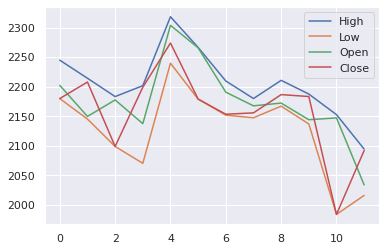

In [ ]:
sns.set_theme()
prices[['High','Low','Open','Close']].plot()

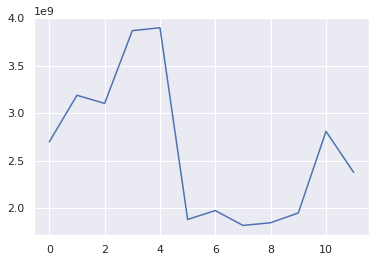

In [ ]:
prices['Volume'].plot()

### **Merging historical market prices and news headline datasets**

In [ ]:
Data = pd.merge(headlines,prices,on='Date',how='right')
Data.head()

,Date,headline_text,sentiment,Open,High,Low,Close,Volume
0,2008-09-15,pregnant watch weight,0.333333,2202.280029,2244.879883,2179.909912,2179.909912,2697820000
1,2008-09-15,cesc fabregas,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000
2,2008-09-15,10 youth walk backwards environment,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000
3,2008-09-15,vacation schools colleges navratri,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000
4,2008-09-15,failure middleorder lanka oneoff thing vengsarkar,-0.316667,2202.280029,2244.879883,2179.909912,2179.909912,2697820000


In [ ]:
Data.shape

(5315, 8)

In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5315 entries, 0 to 5314
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           5315 non-null   datetime64[ns]
 1   headline_text  5315 non-null   object        
 2   sentiment      5315 non-null   float64       
 3   Open           5315 non-null   float64       
 4   High           5315 non-null   float64       
 5   Low            5315 non-null   float64       
 6   Close          5315 non-null   float64       
 7   Volume         5315 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 373.7+ KB


In [ ]:
Data.duplicated().sum()

505

In [ ]:
Data = Data.drop_duplicates(keep='first')

In [ ]:
Data.isnull().sum()

Date             0
headline_text    0
sentiment        0
Open             0
High             0
Low              0
Close            0
Volume           0
dtype: int64

In [ ]:
#Calculation polarity scores for each headline text
Data['score'] = Data['headline_text'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))
Data.head()

,Date,headline_text,sentiment,Open,High,Low,Close,Volume,score
0,2008-09-15,pregnant watch weight,0.333333,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,2008-09-15,cesc fabregas,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,2008-09-15,10 youth walk backwards environment,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,2008-09-15,vacation schools colleges navratri,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,2008-09-15,failure middleorder lanka oneoff thing vengsarkar,-0.316667,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.398, 'neu': 0.602, 'pos': 0.0, 'comp..."


In [ ]:
#Creating Coumpound, pos, neg, neu columns from the polarity score
Data['compound'] = Data['score'].apply(lambda score_dict : score_dict['compound'])
Data['pos'] = Data['score'].apply(lambda score_dict : score_dict['pos'])
Data['neg'] = Data['score'].apply(lambda score_dict : score_dict['neg'])
Data['neu'] = Data['score'].apply(lambda score_dict : score_dict['neu'])
Data.head()

,Date,headline_text,sentiment,Open,High,Low,Close,Volume,score,compound,pos,neg,neu
0,2008-09-15,pregnant watch weight,0.333333,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0,0.000,1.000
1,2008-09-15,cesc fabregas,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0,0.000,1.000
2,2008-09-15,10 youth walk backwards environment,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0,0.000,1.000
3,2008-09-15,vacation schools colleges navratri,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0,0.000,1.000
4,2008-09-15,failure middleorder lanka oneoff thing vengsarkar,-0.316667,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,"{'neg': 0.398, 'neu': 0.602, 'pos': 0.0, 'comp...",-0.5106,0.0,0.398,0.602


In [ ]:
#Deleting the score column
Data = Data.drop('score',axis=1)
Data.head()

,Date,headline_text,sentiment,Open,High,Low,Close,Volume,compound,pos,neg,neu
0,2008-09-15,pregnant watch weight,0.333333,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,0.0000,0.0,0.000,1.000
1,2008-09-15,cesc fabregas,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,0.0000,0.0,0.000,1.000
2,2008-09-15,10 youth walk backwards environment,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,0.0000,0.0,0.000,1.000
3,2008-09-15,vacation schools colleges navratri,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,0.0000,0.0,0.000,1.000
4,2008-09-15,failure middleorder lanka oneoff thing vengsarkar,-0.316667,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,-0.5106,0.0,0.398,0.602


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


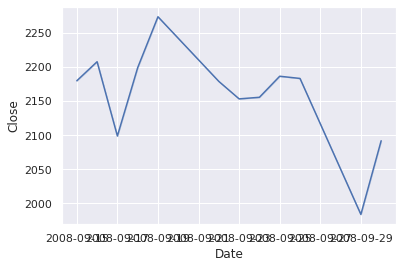

In [ ]:
#Visualising the Date and Close columns
plt.figure()
sns.lineplot(Data['Date'],Data['Close'])

In [ ]:
#Creating price_up column where 1 represents increase in stock and 0 represents decrease or remain unchanged
Data['price_up'] = np.where(Data['Close'].shift(-1)>Data['Close'],1,0)
Data.head()

,Date,headline_text,sentiment,Open,High,Low,Close,Volume,compound,pos,neg,neu,price_up
0,2008-09-15,pregnant watch weight,0.333333,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,0.0000,0.0,0.000,1.000,0
1,2008-09-15,cesc fabregas,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,0.0000,0.0,0.000,1.000,0
2,2008-09-15,10 youth walk backwards environment,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,0.0000,0.0,0.000,1.000,0
3,2008-09-15,vacation schools colleges navratri,0.000000,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,0.0000,0.0,0.000,1.000,0
4,2008-09-15,failure middleorder lanka oneoff thing vengsarkar,-0.316667,2202.280029,2244.879883,2179.909912,2179.909912,2697820000,-0.5106,0.0,0.398,0.602,0


## **Modeling**

In [ ]:
#Splitting dataset into X and y
X = Data[['sentiment','Open','High','Low','Close','Volume','compound','pos','neg','neu']]
y = Data['price_up']

In [ ]:
#Splitting dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(2886, 10)
(1924, 10)


In [ ]:
#Grid search for obtimal parameters
parameters = [{'max_depth' : [10,20], 'n_estimators' : [10,20], 'max_features' : [10,20]}]
model = RandomForestClassifier()
clf = GridSearchCV(model,parameters,cv=5,scoring='roc_auc')
clf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/para

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [10, 20], 'max_features': [10, 20],
                          'n_estimators': [10, 20]}],
             scoring='roc_auc')

In [ ]:
#Best score
clf.best_score_

0.4430763166762951

In [ ]:
#Best parameters
clf.best_params_

{'max_depth': 20, 'max_features': 10, 'n_estimators': 10}

### **Building final model**

In [ ]:
RandClass = RandomForestClassifier(n_estimators=10, max_features=10)
RandClass.fit(X_train,y_train)

RandomForestClassifier(max_features=10, n_estimators=10)

## **Classifier predict**

In [ ]:
y_pred = RandClass.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1923
           1       0.00      0.00      0.00         1

    accuracy                           1.00      1924
   macro avg       0.50      0.50      0.50      1924
weighted avg       1.00      1.00      1.00      1924



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics.accuracy_score(y_test,y_pred)

0.9994802494802495

## **Errors**

In [ ]:
metrics.mean_absolute_error(y_test,y_pred)

0.0005197505197505198

In [ ]:
metrics.mean_squared_error(y_test,y_pred)

0.0005197505197505198